### Главна скрипта за примену ТоМАТо алгоритма на компоненте боје и просторне информације за сегментацију слике

In [1]:
%run imports.ipynb

Учитавамо слику са Лув компонентама боје и оцењујемо густину:

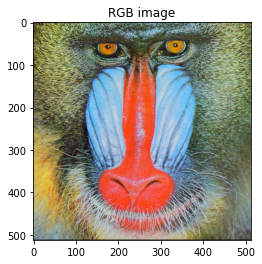

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


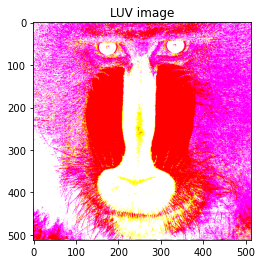

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


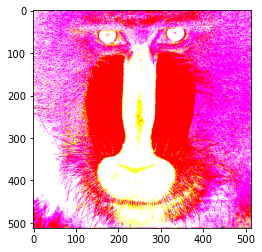

In [3]:
%matplotlib inline
%run ImageSegmentation.ipynb

In [4]:
x = np.vstack((l, u, v)).T
x.shape

(262144, 3)

In [ ]:
%run estimate_density2.ipynb

функција која нам враћа суседни блок пиксела задате величине:

In [5]:
matrix = [[i*img_luv_new.shape[0]+j for j in np.arange(img_luv_new.shape[1])] for i in np.arange(img_luv_new.shape[0])]

In [6]:
def matrix_neighbors(a, radius, rowNumber, columnNumber):
     pom = np.array([[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else -1
                for j in range(columnNumber-radius, columnNumber+radius+1)]
                    for i in range(rowNumber-radius, rowNumber+radius+1)]).flatten()
     return [elem for elem in pom if elem!=-1]

In [7]:
nei_pixels_list = [matrix_neighbors(matrix, radius=5, rowNumber=i, columnNumber=j) for i in np.arange(len(matrix[0])) for j in np.arange(len(matrix))]

In [11]:
kdt = KDTree(x, metric='euclidean')

Рачунамо растојања суседних пиксела у Лув простору да бисмо изабрали одговоарајући радијус у Рипсовом графу.

In [15]:
rastojanja = [np.mean(np.linalg.norm(x[ind]-x[elem]))  
              for ind in range(x.shape[0])
              for elem in nei_pixels_list[ind]]

In [17]:
np.mean([elem for elem in rastojanja if elem!=0])

245.40860417486033

In [21]:
np.median([elem for elem in rastojanja])

0.0

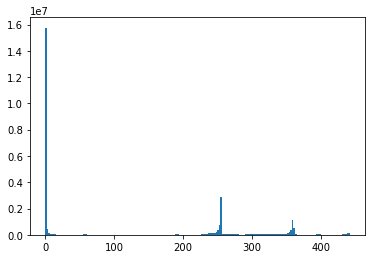

In [19]:
plt.hist(rastojanja, bins=200)
plt.show()

In [15]:
radius = 4

Иницијализовање и претпроцесирање података пре покретања алгоритма.

In [16]:
%run unionfind.ipynb
unf = UnionFind()

In [17]:
index_sorted = np.asarray([i for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])])
vec_sorted = {i:e for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])}
vec_sorted

{31896: 7.176565295863939e-08,
 106244: 7.17656956742265e-08,
 205467: 7.176571009904805e-08,
 98591: 7.176576313237728e-08,
 51002: 7.176580108262649e-08,
 143609: 7.176584841913486e-08,
 128752: 7.17677533891229e-08,
 28824: 7.176958993456794e-08,
 203424: 7.177739842744731e-08,
 215725: 7.177791550000289e-08,
 144519: 7.178711834708166e-08,
 134900: 7.18001712935164e-08,
 33632: 7.180310681118893e-08,
 33946: 7.18194854905852e-08,
 103040: 7.184460303937195e-08,
 189256: 7.184867922456488e-08,
 201405: 7.185494495111699e-08,
 181050: 7.186409685600811e-08,
 32921: 7.187240023127872e-08,
 34445: 7.189712721937785e-08,
 144007: 7.19011598926449e-08,
 58531: 7.19100440843166e-08,
 11800: 7.19373537964086e-08,
 33933: 7.19499755542616e-08,
 26266: 7.195719720121896e-08,
 137460: 7.196926792579043e-08,
 38695: 7.198006916332947e-08,
 135410: 7.198801212422957e-08,
 97567: 7.201943194475255e-08,
 205988: 7.206633737195837e-08,
 128753: 7.207168325135663e-08,
 8255: 7.207874905027213e-08,


Главна функција за имплементацију ТоМАТо алгоритма која враћа хијерархију кластера:

In [18]:
def define_clusters(vec_sorted, radius, tau):

    unf = UnionFind()
    n=len(vec)
    births = {}
    deaths = {}
    for i in reversed(range(n)):
        idx = index_sorted[i]
        nei = kdt.query_radius([x[idx]], radius, return_distance=False)[0]
        S = [elem for elem in nei_pixels_list[idx] if ((elem in index_sorted[(i+1):]) & (elem in nei))] 

        if not S:
            unf.insert_objects([idx]) 
            births[idx] = -vec_sorted[idx]
        else:
            parent = S[np.asarray([vec_sorted[j] for j in S]).argmax()]
            unf.union(parent, idx)
            roots = [unf.find(ele) for ele in S]
            highest = roots[np.asarray([vec_sorted[elem] for elem in roots]).argmax()]
            for root in roots:                   
                if (root != parent) & (vec_sorted[root] - vec_sorted[idx] < tau):
                    unf.union(parent, root)
                    deaths[root] = -vec_sorted[idx]
            if (highest != parent) & (vec_sorted[parent] - vec_sorted[idx] < tau):
                unf.union(highest, parent)
                deaths[parent] = -vec_sorted[idx]
    return unf, births, deaths

In [19]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=np.inf)

In [47]:
for idx in births.keys():
    if (idx not in deaths.keys()):
        deaths[idx] = np.inf

In [48]:
lifecycle = [(births[idx], deaths[idx]) for idx in births.keys()]

In [49]:
res = [(0, elem) for elem in lifecycle]
res

[(0, (-0.0315835807317506, -1.929831574580017e-06)),
 (0, (-0.0315835807317506, -1.146109146578847e-06)),
 (0, (-0.0315835807317506, -1.785764571597144e-06)),
 (0, (-0.0315835807317506, -1.3457844583350867e-06)),
 (0, (-0.0315835807317506, -0.0315835807317506)),
 (0, (-0.0315835807317506, -0.0315835807317506)),
 (0, (-0.0315835807317506, inf)),
 (0, (-0.0315835807317506, -0.0315835807317506)),
 (0, (-0.0315835807317506, -0.0001752068002553)),
 (0, (-0.0315835807317506, -5.1266214742059806e-06)),
 (0, (-0.0315835807317506, -0.0315835807317506)),
 (0, (-0.0315835807317506, -0.0315835807317506)),
 (0, (-0.0315835807317506, -1.7391101989983149e-06)),
 (0, (-0.0315835807317506, -0.011564353215585)),
 (0, (-0.0315835807317506, -0.000217115847213)),
 (0, (-0.0315835807317506, -1.969279566026043e-06)),
 (0, (-0.0315835807317506, -0.0119118145969635)),
 (0, (-0.0315835807317506, -0.0001819114009688)),
 (0, (-0.0315835807317506, -0.0119031279321896)),
 (0, (-0.0315835807317506, -0.00444927501650

In [50]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
sorted([elem for elem in persistence if ~np.isinf(elem)], reverse=True)

[0.031582434622604016,
 0.03158240855528682,
 0.03158223494729226,
 0.031582096450089456,
 0.03158190023135939,
 0.0315818416215516,
 0.03158180558822044,
 0.031581794967179,
 0.03158165090017602,
 0.03158161145218457,
 0.031581237929161,
 0.031579069872332194,
 0.03157845411027639,
 0.0314083739314953,
 0.0314016693307818,
 0.0314016693307818,
 0.0313664648845376,
 0.031364509009248996,
 0.0313137590494419,
 0.029234588654728597,
 0.0271343057152433,
 0.026682874206659497,
 0.02446720020409309,
 0.024467090188238273,
 0.024466932336645392,
 0.024466722874392707,
 0.02446620804593592,
 0.024465868875637935,
 0.024463754700359972,
 0.024460691378961952,
 0.0242595506048413,
 0.0242553593630636,
 0.0242468975251235,
 0.0242447419100395,
 0.0242447419100395,
 0.0242447419100395,
 0.0242447419100395,
 0.0242447419100395,
 0.0242447419100395,
 0.0242447419100395,
 0.0241748159582958,
 0.024166944213453098,
 0.0241478013386523,
 0.0240899465491171,
 0.0240884608617628,
 0.0240884608617628,
 

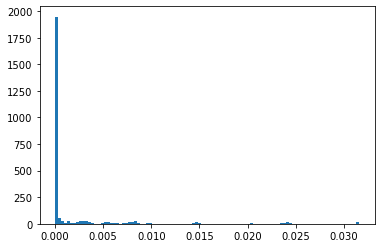

In [51]:
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100)
plt.show()

usetex mode requires TeX.


<Figure size 1296x288 with 0 Axes>

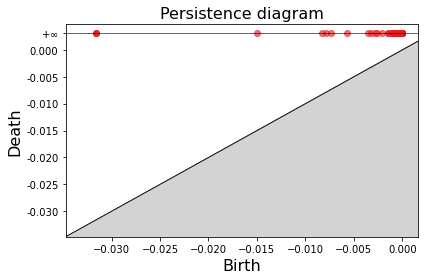

In [52]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_diagram(res)
plt.tight_layout()
plt.show()

<Figure size 1296x288 with 0 Axes>

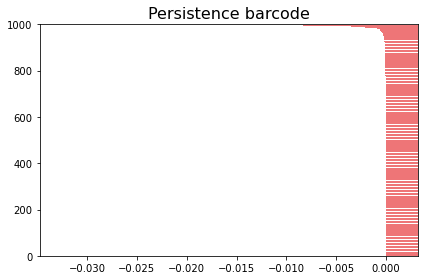

In [53]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

In [ ]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=1e-5)

Број родитеља у хијерархији нам даје тачан број кластера и на основу њих правимо центроиде и одређујемо припадност сваке тачке добијеним кластерима.

In [54]:
len(np.unique(list(unf.parent_pointers.values())))

15443

In [22]:
cen, sts = [], []
ind = np.asarray(list(unf.num_to_objects.values()))
rts = np.asarray(list(unf.parent_pointers.values()))

In [23]:
for ele in np.unique(rts):

    cen.append(unf.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [24]:
cen = np.asarray(cen)

In [25]:
cen

array([ 91851, 105265, 169652, ..., 205467, 106244,  31896])

In [26]:
sts

[array([108197, 140445,  84147, ..., 117374, 107650, 108674]),
 array([107845,  61760, 126776, ..., 101242, 100218, 176425]),
 array([170165, 170676, 170678, 170166, 171190, 171186, 170675, 171188,
        167606, 169139, 170677, 171187]),
 array([136526]),
 array([139074, 137027]),
 array([144533, 152216]),
 array([127626, 155806, 149655, 156315, 131213, 133262, 148117, 127114,
        153242, 150679, 147606, 156828, 135821, 144021, 145558, 130186,
        125577, 153241, 133772, 137870, 125065, 136845, 130188, 127625,
        136846, 156827, 124553, 141970, 157855, 128651, 135307, 133770,
        135308, 152213, 128139, 128650, 151191, 135819, 152215, 119941,
        133258, 118404, 151192, 135818, 125066, 128137, 143507, 130698,
        138386, 135305, 137871, 133259, 112771, 154778, 130185, 135823,
        137358, 128649, 148115, 145560, 141969, 142997, 159906, 137356,
        127116, 131209, 149142]),
 array([62661, 64191, 65213, 62674, 70342, 66238, 62142, 67788, 57554,
        7

In [27]:
threshold = 100
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    print(len(elem))
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

14247
18069
12
1
2
2
67
14
4
81
1
1
9
20896
2
1
219
875
12
1
10
1
5
3
1
1
261
2
1
4
2
2
1
2
1
6
1
2
4
1
6
1
1
1
24
2
1
1
1
1
2
3
1
2
1
2
1
1
1
1
9
1
1
1
2
15
1
1
1
1
1
2
1
1
1
1
5
3
19
1
4
8
1
3
14
1
1
2
2
2
2
1
2
6
2
1
1
1
1
1
1
1
1
4
3
1
2
1
2
1
2
16
3
6
2
1
1
1
5
1
2
1
1
11
1
1
2
1
1
1
1
1
1
7
1
3
1
1
1
1
1
1
1
1
1
1
2
2
1
2
2
1
1
1
1
2
2
2
1
1
1
1
8
1
2
1
1
1
1
5
1
1
1
2
2
1
1
2
5
1
1
1
1
1
1
4
1
1
1
1
1
3
1
1
2
1
1
1
3
1
1
1
1
1
1
1
4
2
1
1
1
1
1
1
1
1
2
1
3
1
1
1
2
8
1
2
1
2
3
1
1
1
1
11
1
4
1
1
1
1
1
1
2
2
1
2
1
1
2
1
1
1
1
1
1
1
1
299
1
1
1
1
1
1
1
1
1
2
2
13
1
1
15
2
1
1
1
2
2
1
1
1
2
5
1
3
5
1
111
4
13
4
2
2
7
35
1
32
1
6
9
9
2
1
1
2
5
1
1
4
1
1
1
1
1
2
97
9
2
2
24
3
1
2
2
3
19
6
1
1
4
116
41
1
1
4
2
6
4
1
4
1
7
5
1
11
2
1
37
1
1
1
4
51
14
4
20
46
4
10
1
2
2
1
1
1
3
1
19
11
3
3
1
11
1
1
1
33
2
54
1
2
1
29
3
4
1
1
2
1
1
12
67
2
1
1
3
2
3054
1
1
1
2
103
2
134
7
5878
1
1
6
8
9
1
3
7
2
3
1
2
1
64
5
8
7
2
2
9
1
1
1
1
3
2
2
241
1
9
1
1
5
1
1
1
1
9
1
15
1
1
1
1
16
7
3
1
4
1
1
1
4
1


1
2
5
1
31
1
1
1
1
1
1
5
2
1
1
1
1
2
4
1
1
3
5
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
13
1
1
1
1
4
1
1
1
1
2
3
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
2
1
1
4
1
2
1
4
1
1
1
1
2
3
1
1
2
1
2
3
2
1
3
1
1
1
1
1
1
1
1
1
1
4
1
1
2
1
1
1
1
4
1
1
1
2
1
1
3
1
3
1
1
1
1
3
1
1
3
1
1
1
1
1
1
1
2
1
1
1
1
1
8
1
1
1
1
2
2
32
1
3
2
1
2
2
1
1
1
1
1
3
1
1
2
1
3
2
4
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
252
1
1
1
1
2
1
1
1
1
4
2
1
2
1
1
1
1
9
3
1
19
1
2
3
1
1
1
1
10
1
1
1
20
1
1
1
1
1
2
1
1
1
3
2
2
2
3
1
1
4
1
1
1
1
1
60
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
5
1
1
3
1
1
1
1
2
2
3
2
1
1
1
1
1
2
1
4
1
1
1
1
1
1
1
1
1
1
1
1
3
2
1
1
3
1
1
1
3
1
1
1
1
1
2
2
1
1
2
1
1
2
1
1
1
1
3
4
1
3
1
1
1
1
1
1
1
1
4
5
5
1
1
4
3
1
1
1
1
1
1
1
1
50
1
1
1
1
1
1
1
2
8
1
2
1
9
2
1
1
1
1
4
1
1
2
1
1
1
1
2
3
2
1
1
1
1
3
1
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
2
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
2
2
1
1
1
1
1
1
3
1
1
2
1
1
1
2
2
1
1
1
1
2
2
6
1
1
1
2
2
1
2
2
1
1
8
2
1
2
1
2
2
5


1
1
1
4
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
7
1
1
2
2
1
1
2
1
1
1
1
1
1
1
3
2
2
3
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
2
1
1
1
2
1
1
4
3
1
1
2
1
1
1
1
2
1
1
1
1
1
3
2
3
1
1
1
1
1
1
4
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
4
1
2
1
1
1
1
1
3
1
1
2
1
1
3
1
1
4
2
1
5
1
1
1
1
1
2
1
3
2
1
1
1
1
1
4
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
2
1
2
6
1
2
1
1
1
3
1
2
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
7
1
2
3
1
1
2
1
3
1
4
1
2
6
1
1
1
1
1
1
1
1
1
4
2
1
1
1
10
1
1
1
1
1
2
2
2
1
1
1
1
1
1
3
1
1
1
1
1
2
11
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
2
2
6
1
1
1
2
2
1
1
1
1
1
1
1
1
1
2
2
1
1
3
2
1
1
1
1
1
1
4
1
1
1
1
1
23
1
1
1
1
2
1
1
1
1
1
1
2
1
5
1
4
1
1
1
1
1
2
4
1
2
1
1
2
2
1
1
1
1
1
1
1
2
1
2
1
1
2
1
1
4
1
2
1
1
4
1
1
1
1
1
2
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
5
2
3
6
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
2
1
1
1
1
1
1
2
2
2
1
4
3
4
1
1
1
1
1
1
4
1
1
1
1
8
1
3
1
1
2
1
2
1
1
2
1
1
1
1
2
1
1

1
1
1
2
1
2
1
1
3
1
2
2
1
3
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
3
1
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
3
4
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
2
14
1
2
1
1
1
1
1
1
4
1
1
2
1
2
1
3
1
1
13
1
1
1
3
1
3
1
1
1
1
1
4
1
1
1
1
3
1
32
1
1
1
4
1
1
1
1
4
1
8
3
1
3
4
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
2
2
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
2
1
2
2
1
1
1
1
2
1
2
1
1
1
1
1
1
11
1
1
2
3
2
1
2
2
1
1
1
1
2
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
3
1
1
3
1
1
1
1
4
2
1
7
6
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
2
3
1
2
2
3
1
2
1
1
1
1
1
1
2
1
1
1
2
3
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
2
1
1
2
1
3
1
1
1
1
1
1
1
1
1
2
1
2
1
1
2
3
2
1
1
2
1
1
1
2
3
1
1
1
2
1
4
1
4
1
1
2
2
1
1
1
1
1
2
2
2
1
1
1
1
1
1
3
1
3
3
2
1
2
1
1
1
1
1
1
2
3
4
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
2
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
2
1
3
1
2
1
1
1
1
1
1
1
1
2
1
2
2
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1


1
1
1
10
1
1
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
6
2
1
1
1
1
1
1
6
1
1
3
1
3
1
1
8
1
1
1
1
2
1
4
2
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
2
1
2
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
5
2
1
3
1
3
1
1
2
1
1
1
1
1
2
1
2
1
1
1
2
1
2
1
1
1
1
1
2
1
2
7
1
1
1
1
1
4
1
1
1
1
2
2
6
1
1
1
2
1
1
1
2
1
1
1
2
46
2
1
1
2
1
3
1
1
1
1
1
1
5
1
1
1
1
6
2
1
1
1
1
1
1
2
1
1
1
2
1
2
1
1
3
1
1
1
2
3
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
4
6
2
1
1
1
3
4
1
1
1
2
1
3
2
1
2
1
1
1
1
1
3
2
1
1
1
1
1
1
2
1
1
1
1
1
1
4
2
1
1
6
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
2
1
4
1
1
3
1
1
1
2
1
1
1
1
1
1
1
1
3
2
2
2
4
1
6
2
1
4
1
1
1
1
1
1
2
1
1
8
1
1
1
2
1
1
2
3
1
1
1
1
1
1
2
1
3
2
2
1
1
1
1
1
1
2
1
1
2
3
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
14
1
2
1
1
2
1
1
1
2
1
1
1
4


1
2
2
1
1
1
1
1
1
1
1
2
4
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
3
1
4
1
1
2
1
1
10
1
1
1
1
3
1
3
1
1
1
1
1
1
1
1
5
1
1
1
2
1
7
1
2
1
1
1
1
1
2
1
1
1
4
1
1
1
1
3
1
1
2
1
1
4
1
2
1
2
6
1
1
1
3
1
1
1
1
1
1
1
1
1
1
4
1
1
1
4
1
1
4
1
1
2
2
1
2
1
1
2
4
1
1
1
2
1
1
1
1
1
1
2
1
1
2
11
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
2
2
2
1
1
1
2
1
1
3
1
2
2
1
1
1
1
1
2
1
1
1
1
2
2
1
1
2
2
3
1
1
11
1
1
1
1
1
2
1
2
1
1
1
2
1
1
1
2
1
1
3
1
2
1
1
2
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
2
5
1
2
1
1
1
1
1
1
1
1
3
1
1
1
3
1
23
1
1
2
1
5
1
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
4
1
1
3
1
1
1
1
1
1
3
2
1
1
2
4
1
1
1
2
2
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
7
2
4
1
1
1
1
2
1
1
1
1
1
1
1
14
5
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
4
1
2
1
3
2
2
1
1
1
3
3
1
1
1
3
2
1
2
1
1
1
3
2
1
1
1
1
1
1
4
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
3
1
1
1
1
1
1
3
1
1
1
1
1
1
1
3
1
2
2
1
1
1
1
1
2
1
1
1

2
1
1
1
1
1
1
1
1
1
2
1
1
5
1
1
1
1
1
2
1
3
1
1
2
1
1
1
4
4
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
3
1
1
1
1
1
5
1
3
1
2
1
3
1
1
1
1
1
1
1
10
1
1
4
1
1
1
1
2
2
4
1
1
1
1
1
2
1
5
1
1
3
1
1
1
2
7
3
1
1
1
1
4
1
1
3
1
1
2
2
1
1
1
1
1
3
1
1
1
1
1
2
1
2
1
1
1
1
5
1
1
1
1
1
1
1
1
4
1
1
1
2
1
1
5
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
3
1
1
1
1
1
1
1
2
2
2
1
1
1
21
2
1
1
1
1
1
1
3
1
1
5
1
2
2
2
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
10
1
1
1
1
1
2
1
1
3
1
3
1
1
1
1
1
1
1
1
25
1
1
3
4
1
1
1
1
1
1
1
1
1
11
1
1
2
1
1
2
1
1
1
2
1
1
1
1
9
1
1
1
2
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
2
1
6
1
2
1
1
1
5
1
1
1
2
1
1
1
1
1
1
2
6
1
13
2
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
3
1
1
1
3
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
10
1
3
2
1
1
1
1
1
1
3
1
1
1
2
1
1
2
3
1
1
1
1
1
1
1
1
1
2
1
4
1
1
1
1
2
1
1
2
1
1
3
3
1
2
1
10
1
1
1
1
1
1
1
60
1
1
1
2
1

1
1
2
1
1
3
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
2
1
1
2
1
1
1
1
2
6
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
10
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
2
1
1
4
1
3
2
1
1
2
2
1
1
1
1
1
1
1
1
3
1
1
2
2
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
2
1
1
1
3
2
1
1
42
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
4
1
2
2
1
1
1
1
1
1
1
5
1
2
1
1
4
1
1
1
3
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
4
1
2
2
1
1
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
1
2
1
2
1
1
2
1
1
1
2
1
1
2
1
1
1
1
1
1
9
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
3
1
1
1
2
1
1
1
1
5
7
1
2
1
1
1
1
1
1
1
1
12
1
1
1
2
2
1
2
1
2
1
1
1
2
1
3
1
2
2
1
1
2
1
1
1
1
3
1
1
6
1
4
1
1
1
4
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1

2
1
2
1
2
1
9
1
1
2
1
2
1
4
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
9
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
43
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
2
4
1
1
1
1
2
1
1
3
1
2
1
7
1
1
1
5
3
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
20
1
1
1
1
1
9
1
1
1
1
6
1
3
1
3
1
1
1
1
4
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
5
2
1
1
1
1
1
1
1
2
3
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
3
1
5
1
1
1
2
1
1
1
2
1
10
1
1
4
1
1
1
1
1
1
1
7
1
1
1
1
1
21
1
1
1
5
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
6
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
2
1
1
1
1
2
1
3
2
1
1
1
1
1
1
1
1
2
1
2
2
1
1
1
4
4
1
1
1
1
2
1
2
1
1
2
2
1
1
1
1
2
3
1
2
1
1
1
2
1
1
1
1
1
2
1
1
2
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
4
1
1
1
1
1
3
2
1
2
1
1
4
1
3
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
3
1
1
1
1
1
1
1
4
1
1
7
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
1
1
1
2
1


1
2
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
5
16
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
2
1
1
1
1
1
1
2
2
1
3
1
1
1
2
1
1
2
1
2
1
1
1
1
3
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
4
1
1
2
1
1
2
1
1
3
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
1
2
1
1
1
1
3
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
11
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
3
1
1
1
4
2
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
3
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
2
1
1
7
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
2
1
2
2
2
1
2
1
1
1
3
1
5
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
6
1
1
3
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
3
1
1
2
1
2
1
1
1
1
1
3
1
1
1
1
1
1
2
1
3
2
2
1


3
1
20
1
2
1
5
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
2
1
2
1
2
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
5
1
1
1
1
2
2
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
2
1
7
5
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
1
1
1
1
2
1
1
1
1
1
2
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
8
1
1
1
1
1
5
3
1
1
1
1
1
2
2
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
8
1
1
1
1
1
5
1
1
1
2
2
1
2
2
1
1
2
1
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
22
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
3
1
2
1
1
1
1
1
1
1
1
1
1
5
1
1
2
2
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
5
1
1
1
8
1
1
2
1
1
1
1
1
1
1
1
1


2
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
2
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
6
2
1
1
1
7
1
1
1
2
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
5
1
1
2
2
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
8
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
5
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
6
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
7
3
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
3
2
1
1
1
1
3
1
1
1
2
1
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
2
1
1
9
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1


1
2
1
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
8
1
1
1
1
1
6
2
2
1
1
1
1
8
1
1
1
1
1
2
1
1
1
1
1
1
3
1
3
1
1
1
1
1
1
1
1
1
1
2
1
1
2
2
1
1
1
1
1
8
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
4
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
4
1
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
2
1
1
1
3
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
3
2
1
1
1
1
4
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
2
2
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
4
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
2
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
3
2
3
1
1
1
2
1
1
1
2
3
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
3
1
4
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
2
11
1
5
5
1
3
1
1
3
1
1
1
1
1
3
1
2
1
1
2
1
1
1
1
2
1
1
1
1
2
5
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
3
1
2
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
3
1
1
1
1
1
1
1
2
1
1
1
1
1
11
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
1
2
1


1
1
1
1
2
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
4
1
1
2
1
1
1
1
2
1
1
1
1
1
2
2
1
1
3
1
1
1
4
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
3
2
1
2
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
3
1
1
1
4
1
1
7
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
4
1
2
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
1
1
1
2
1
2
1
1
1
1
1
9
1
1
1
1
1
1
1
1
6
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
2
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
2
1
1
1
2
4
1
1
1
3
1
1
1
2
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
3
1
4
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
14
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1

In [49]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+111)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0, 0, 0])
    return colors
colors = cluster_color(cen)

In [37]:
idxs = []
for idx, grp in enumerate(sts):
    idxs = idxs + list(np.repeat(idx, len(sts[idx])))

In [38]:
grps = []
for idx, grp in enumerate(sts):
    grps = grps + list(grp)

In [39]:
cluster_sort = sorted(zip(grps, idxs))

In [50]:
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]

In [52]:
img_clustered_all = np.reshape(np.asarray(img_clustered), img_luv_new.shape)

Финални резултат ТоМАТо алгоритма:

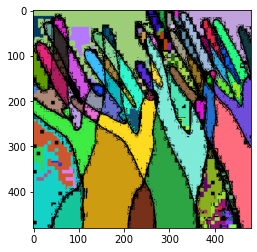

In [37]:
plt.imshow(img_clustered_all)

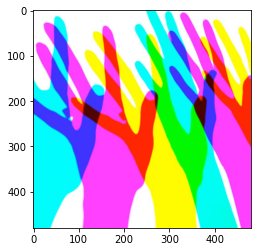

In [38]:
plt.imshow(img_rgb)